In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from keras.layers import Input, Dense, Lambda, Reshape
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

In [2]:
batch_size = 100 
original_dim = 784 #←--- MNIST图像的高×宽
latent_dim = 2
intermediate_dim = 256
EPOCHS = 5 #←--- epoch数
epsilon_std = 1.0

In [3]:
def sampling(args):
 z_mean, z_log_var = args 
 epsilon = K.random_normal(shape=(batch_size, latent_dim),mean=0.)
 return z_mean + K.exp(z_log_var / 2) * epsilon

In [4]:
#encoder
x = Input(shape=(original_dim,), name="input") #←--- 编码器的输入
h = Dense(intermediate_dim, activation='relu', name="encoding")(x) #←--- 中间层
z_mean = Dense(latent_dim, name="mean")(h) #←--- 定义潜在空间的均值
z_log_var = Dense(latent_dim, name="log-variance")(h) #←--- 定义潜在空间的log variance
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean,z_log_var]) #←--- 注意，output_shape不是一定要用TensorFlow后端
encoder = Model(x, [z_mean, z_log_var, z], name="encoder") #←--- 将编码器定义为一个Keras模型
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoding (Dense)               (None, 256)          200960      ['input[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            514         ['encoding[0][0]']               
                                                                                                  
 log-variance (Dense)           (None, 2)            514         ['encoding[0][0]']               
                                                                                            

In [5]:
#decoder
input_decoder = Input(shape=(latent_dim,), name="decoder_input") #←--- 解码器的输入
decoder_h = Dense(intermediate_dim, activation='relu',name="decoder_h")(input_decoder) #←--- 潜在空间转化为中间维度
x_decoded = Dense(original_dim, activation='sigmoid',name="flat_decoded")(decoder_h) #←--- 得到原始维度的平均值
decoder = Model(input_decoder, x_decoded, name="decoder") #←---将解码器定义为一个Keras模型
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 decoder_h (Dense)           (None, 256)               768       
                                                                 
 flat_decoded (Dense)        (None, 784)               201488    
                                                                 
Total params: 202,256
Trainable params: 202,256
Non-trainable params: 0
_________________________________________________________________


In [6]:
output_combined = decoder(encoder(x)[2]) #←--- 抓取输出需要获取第三个元素，即采样z
vae = Model(x, output_combined) #←--- 连接输入和总输出
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (100, 2)]                          
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [7]:
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,
            z_log_var=z_log_var, z_mean=z_mean,
            original_dim=original_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(
        1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss
vae.add_loss(vae_loss(x,output_combined))
#vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          201988      ['input[0][0]']                  
                                 (None, 2),                                                       
                                 (100, 2)]                                                        
                                                                                                  
 decoder (Functional)           (None, 784)          202256      ['encoder[0][2]']                
                                                                                              

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train),np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


In [9]:
vae.fit(x_train,
        shuffle=True, 
        epochs=EPOCHS,
        batch_size=batch_size,
        verbose=1)


Epoch 1/5
600/600 [==============================] - 5s 6ms/step - loss: 191.7004
Epoch 2/5
600/600 [==============================] - 5s 8ms/step - loss: 170.4718
Epoch 3/5
600/600 [==============================] - 5s 9ms/step - loss: 167.1189
Epoch 4/5
600/600 [==============================] - 5s 9ms/step - loss: 164.9403
Epoch 5/5
600/600 [==============================] - 5s 9ms/step - loss: 163.3441


100/100 [==============================] - 0s 1ms/step


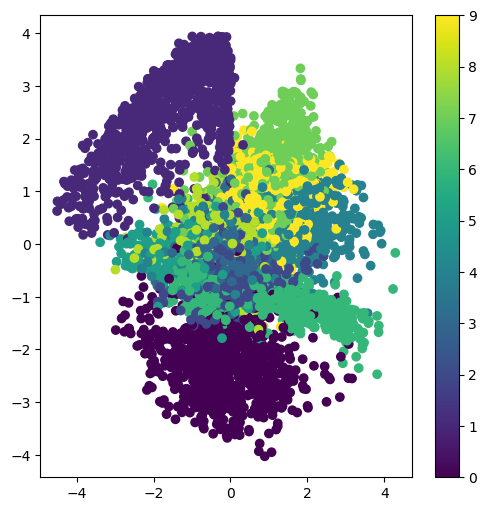

In [10]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)[0]
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

1/1 [==============================] - 0s 14ms/step


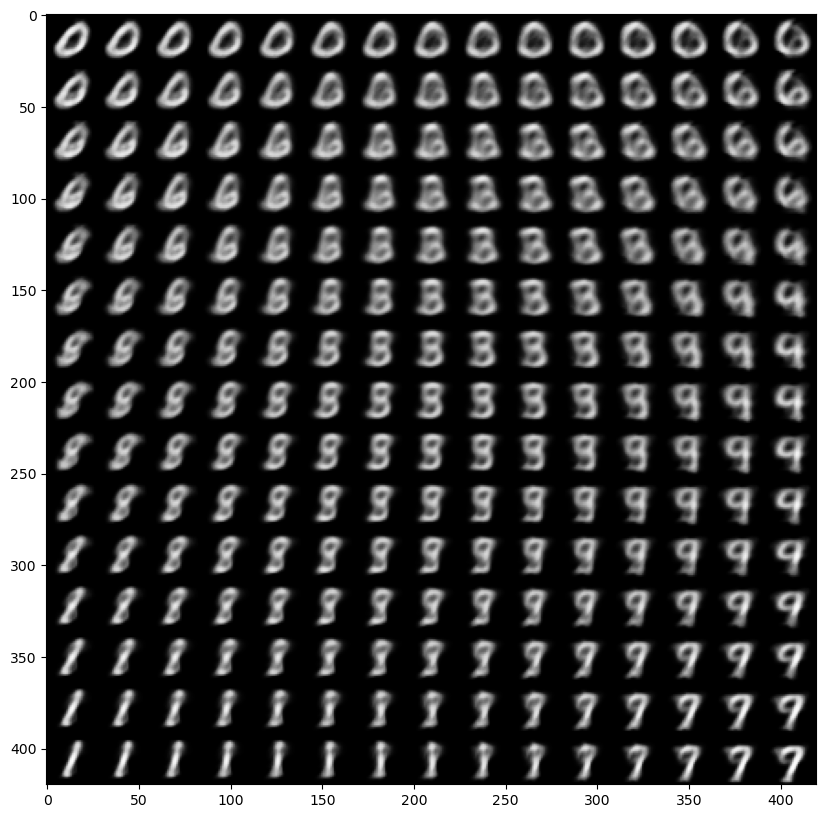

In [11]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()